# Casos de Uso
Investigación Big Data

In [1]:
# Herramienta DBCV
!pip install "git+https://github.com/FelSiq/DBCV"

  Cloning https://github.com/FelSiq/DBCV to /tmp/pip-req-build-mvuduh72
  Running command git clone --filter=blob:none --quiet https://github.com/FelSiq/DBCV /tmp/pip-req-build-mvuduh72
  Resolved https://github.com/FelSiq/DBCV to commit 13c3896ef78d12f1e3e1cbd394f2db9a09637ffd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbcv: filename=dbcv-0.1.1-py3-none-any.whl size=6667 sha256=e1942754fc0cc025c0718dcdfd0920dda719ae62d05326799865d80d7579cc07
  Stored in directory: /tmp/pip-ephem-wheel-cache-uyasyxmq/wheels/e4/c0/55/b233329a5a47c9f54996729cf3c8166850a51f37b0aa911081
Successfully built dbcv


In [2]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import dbcv
import hdbscan
import plotly.express as px
import time, psutil, os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

proc = psutil.Process(os.getpid())

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Dataset sintético: make_moons little noise

In [3]:
X, y_true = make_moons(n_samples=1_000,
                       noise=0.05,
                       random_state=42)

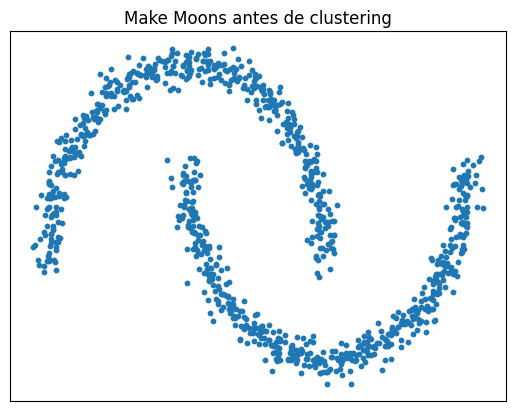

In [4]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Make Moons antes de clustering")
plt.xticks([]); plt.yticks([])
plt.show()

In [5]:
X_std = StandardScaler().fit_transform(X)

### DBSCAN

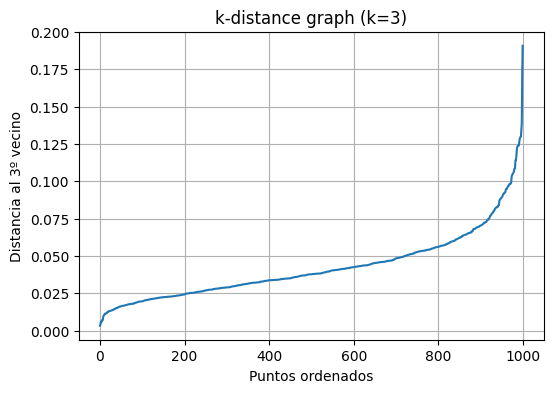

In [6]:
nbrs = NearestNeighbors(n_neighbors=3).fit(X_std)
distances, _ = nbrs.kneighbors(X_std)
k_dist = np.sort(distances[:, 2])

# Grafica
plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel('Distancia al 3º vecino')
plt.xlabel('Puntos ordenados')
plt.title('k-distance graph (k=3)')
plt.grid(True)
plt.show()

Tiempo de ejecución: 0.01 segundos.
Uso de memoria: 282.33984375 MB.
Clusters definidos:  11


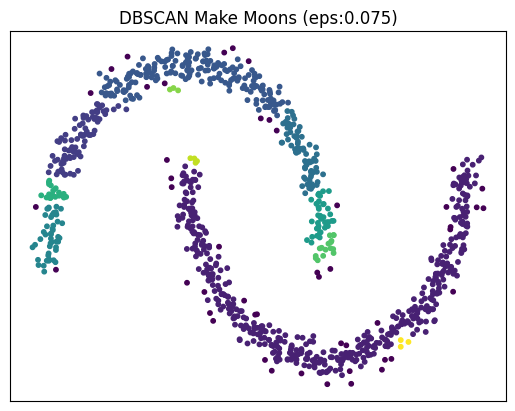

In [7]:
t0 = time.perf_counter()
dbscan = DBSCAN(eps=0.075, min_samples=3)
db_labels = dbscan.fit_predict(X_std)
elapsed = time.perf_counter() - t0
print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")
mem_after = proc.memory_info().rss / 1024 / 1024
print(f"Uso de memoria: {mem_after} MB.")
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("Clusters definidos: ", n_clusters)

plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], s=10, c=db_labels, cmap="viridis")
plt.title("DBSCAN Make Moons (eps:0.075)")
plt.xticks([]); plt.yticks([])
plt.show()

### Evaluación de los resultados con DBCV


In [8]:
score = dbcv.dbcv(X_std, db_labels)
print(f"DBCV Score:{score:.3f}")

DBCV Score:-0.281


### HDBSCAN

5% de la muestra: 50
Tiempo de ejecución: 0.03 segundos.
Uso de memoria: 293.4140625 MB.
Clusters definidos:  2


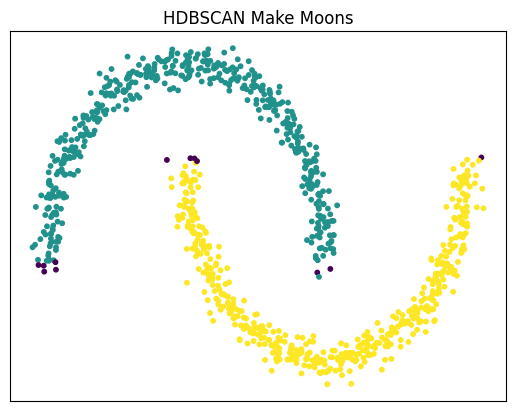

In [9]:
five_percent = int(len(X_std) * 0.05)
print(f"5% de la muestra: {five_percent}")
t0 = time.perf_counter()
hdb = hdbscan.HDBSCAN(min_cluster_size=five_percent)
hdb_labels = hdb.fit_predict(X_std)

elapsed = time.perf_counter() - t0
print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")

mem_after = proc.memory_info().rss / 1024 / 1024
print(f"Uso de memoria: {mem_after} MB.")

n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print("Clusters definidos: ", n_clusters)

plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], s=10, c=hdb_labels, cmap="viridis")
plt.title("HDBSCAN Make Moons")
plt.xticks([]); plt.yticks([])
plt.show()

### Evaluación de los resultados con DBCV


In [10]:
score = dbcv.dbcv(X_std, hdb_labels)
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.915


## Dataset Sintético Ruido Aumentado

In [11]:
X, y_true = make_moons(n_samples=1_000,
                       noise=0.2,
                       random_state=42)

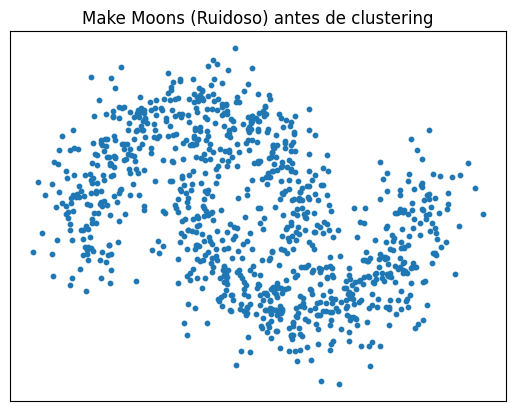

In [ ]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Make Moons (Ruidoso) antes de clustering")
plt.xticks([]); plt.yticks([])
plt.show()

In [12]:
X_std = StandardScaler().fit_transform(X)

### DBSCAN

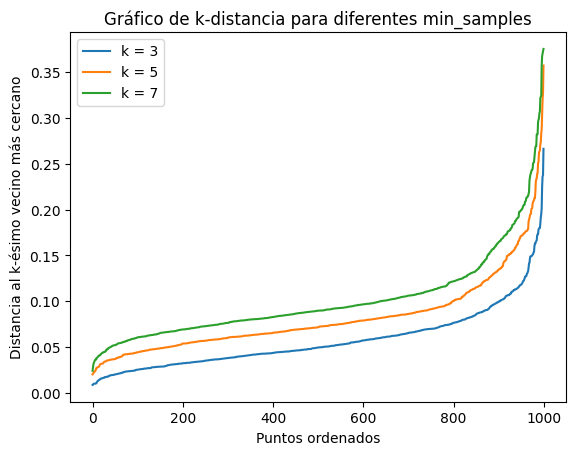

In [13]:
for k in [3, 5, 7]:
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances, label=f'k = {k}')

plt.title('Gráfico de k-distancia para diferentes min_samples')
plt.xlabel('Puntos ordenados')
plt.ylabel('Distancia al k-ésimo vecino más cercano')
plt.legend()
plt.show()

In [14]:
eps_values = np.linspace(0.06, 0.13, 10)
min_samples_values = [3, 5, 7]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(X_std)

        n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        if n_clusters < 2:
            continue

        n_noise = np.sum(db_labels == -1)
        noise_pct = n_noise / len(db_labels)
        score = dbcv.dbcv(X_std, db_labels)

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "noise_pct": noise_pct,
            "DBCV": score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="DBCV", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df.head()

,eps,min_samples,n_clusters,n_noise,noise_pct,DBCV
0,0.075556,3,95,358,0.358,0.424350
1,0.067778,3,99,435,0.435,0.422349
2,0.060000,3,99,517,0.517,0.382979
3,0.091111,5,53,458,0.458,0.359193
4,0.083333,3,88,281,0.281,0.320782


Tiempo de ejecución: 0.01 segundos.
Uso de memoria: 301.58984375 MB.
Clusters definidos:  94


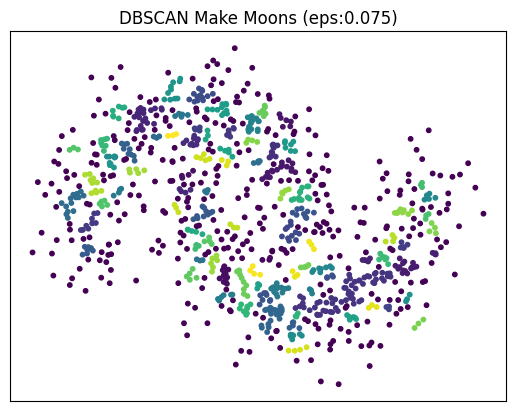

In [15]:
t0 = time.perf_counter()
dbscan = DBSCAN(eps=0.075, min_samples=3)
db_labels = dbscan.fit_predict(X_std)
elapsed = time.perf_counter() - t0
print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")
mem_after = proc.memory_info().rss / 1024 / 1024
print(f"Uso de memoria: {mem_after} MB.")
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("Clusters definidos: ", n_clusters)

plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], s=10, c=db_labels, cmap="viridis")
plt.title("DBSCAN Make Moons (eps:0.075)")
plt.xticks([]); plt.yticks([])
plt.show()

### Evaluación de los resultados con DBCV


In [16]:
score = dbcv.dbcv(X_std, db_labels)
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.420


### HDBSCAN

In [17]:
five_percent = int(len(X_std) * 0.05)
print(f"5% de la muestra: {five_percent}")
ten_percent = int(len(X_std) * 0.1)
print(f"10% de la muestra: {ten_percent}")

min_cluster_sizes = np.linspace(five_percent, ten_percent, 5, dtype=int)
min_samples_values = [None, 3, 5, 7]
grid_results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        hdbscan_labels = hdb.fit_predict(X_std)

        n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
        if n_clusters < 2:
            continue

        n_noise = np.sum(hdbscan_labels == -1)
        noise_pct = n_noise / len(hdbscan_labels)
        score = dbcv.dbcv(X_std, hdbscan_labels)


        grid_results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "noise_pct": noise_pct,
            "DBCV": score
        })

results_df = pd.DataFrame(grid_results)
results_df = results_df.sort_values(by="DBCV", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df.head()

5% de la muestra: 50
10% de la muestra: 100


,min_cluster_size,min_samples,n_clusters,n_noise,noise_pct,DBCV
0,75,NaN,2,459,0.459,0.484625
1,87,NaN,2,458,0.458,0.455910
2,100,NaN,2,504,0.504,0.417351
3,50,7.0,2,283,0.283,0.107596
4,87,7.0,2,283,0.283,0.107596


Tiempo de ejecución: 0.02 segundos.
Uso de memoria: 310.0703125 MB.
Clusters definidos:  2


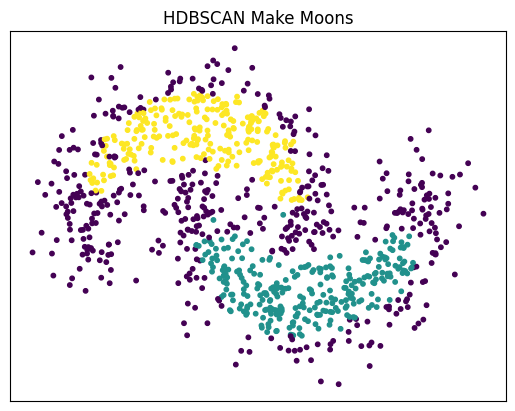

In [18]:
t0 = time.perf_counter()
hdb = hdbscan.HDBSCAN(min_cluster_size=75)
hdb_labels = hdb.fit_predict(X_std)

elapsed = time.perf_counter() - t0
print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")

mem_after = proc.memory_info().rss / 1024 / 1024
print(f"Uso de memoria: {mem_after} MB.")

n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print("Clusters definidos: ", n_clusters)

plt.figure()
plt.scatter(X_std[:, 0], X_std[:, 1], s=10, c=hdb_labels, cmap="viridis")
plt.title("HDBSCAN Make Moons")
plt.xticks([]); plt.yticks([])
plt.show()

### Evaluación de los resultados con DBCV


In [19]:
score = dbcv.dbcv(X_std, hdb_labels)
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.485


## Dataset Real: Wholesale Customers Data Set

In [21]:
wholesale_customers_file = files.upload()

Saving Wholesale customers data.csv to Wholesale customers data.csv


In [22]:
wc_dataset = pd.read_csv("Wholesale customers data.csv")
print(wc_dataset.head(20))

    Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0         2       3  12669   9656     7561     214              2674   
1         2       3   7057   9810     9568    1762              3293   
2         2       3   6353   8808     7684    2405              3516   
3         1       3  13265   1196     4221    6404               507   
4         2       3  22615   5410     7198    3915              1777   
5         2       3   9413   8259     5126     666              1795   
6         2       3  12126   3199     6975     480              3140   
7         2       3   7579   4956     9426    1669              3321   
8         1       3   5963   3648     6192     425              1716   
9         2       3   6006  11093    18881    1159              7425   
10        2       3   3366   5403    12974    4400              5977   
11        2       3  13146   1124     4523    1420               549   
12        2       3  31714  12319    11757     287              

In [23]:
print(wc_dataset.size)

3520


In [24]:
scaler = StandardScaler()
wc_data = scaler.fit_transform(wc_dataset)

### Visualización de datos con PCA (Reduce dimensionalidad) y plotly

In [25]:
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(wc_data)

df_pca = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3", title="Wholesale Costumers")
fig.show()


### DBSCAN

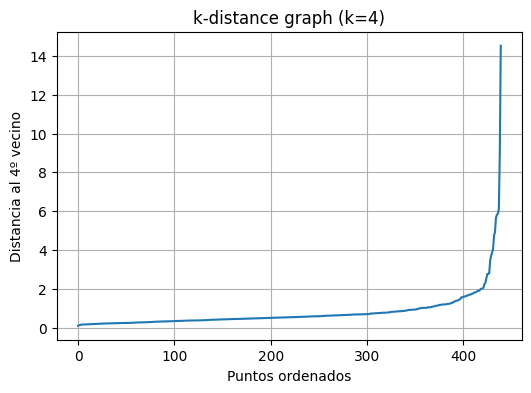

In [26]:
nbrs = NearestNeighbors(n_neighbors=4).fit(wc_data)
distances, _ = nbrs.kneighbors(wc_data)
k_dist = np.sort(distances[:, 2])

# Grafica
plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel('Distancia al 4º vecino')
plt.xlabel('Puntos ordenados')
plt.title('k-distance graph (k=4)')
plt.grid(True)
plt.show()

In [27]:
eps_values = np.linspace(1.8, 2.3, 10)
min_samples_values = [3, 4, 5, 6, 7]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        db_labels = dbscan.fit_predict(wc_data)

        n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        if n_clusters < 2:
            continue

        n_noise = np.sum(db_labels == -1)
        noise_pct = n_noise / len(db_labels)
        score = dbcv.dbcv(wc_data, db_labels)

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "noise_pct": noise_pct,
            "DBCV": score
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="DBCV", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df.head()

,eps,min_samples,n_clusters,n_noise,noise_pct,DBCV
0,1.800000,4,2,22,0.050000,0.212845
1,1.966667,6,2,22,0.050000,0.212845
2,1.855556,5,2,24,0.054545,0.212707
3,1.911111,5,2,24,0.054545,0.212707
4,1.911111,6,2,25,0.056818,0.212636


In [28]:
t0 = time.perf_counter()
wc_dbscan = DBSCAN(eps = 1.8, min_samples = 4)
wc_dbscan.fit(wc_data)
elapsed = time.perf_counter() - t0
mem_after = proc.memory_info().rss / 1024 / 1024


### Resultados de DBSCAN con PCA y plotly

In [29]:
dbscan_df = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
dbscan_df["Cluster"] = wc_dbscan.labels_

fig = px.scatter_3d(dbscan_df, x="PC1", y="PC2", z="PC3",
                    color=dbscan_df["Cluster"].astype(str),
                    title="Resultados con DBSCAN")

# Obtiene el número de clusters sin contar el ruido:
print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")

print(f"Uso de memoria: {mem_after} MB.")
n_clusters = dbscan_df["Cluster"].nunique() - (1 if -1 in dbscan_df["Cluster"].values else 0)
print("Clusters definidos: ", n_clusters)

fig.show()

Tiempo de ejecución: 0.01 segundos.
Uso de memoria: 337.08984375 MB.
Clusters definidos:  2


### Evaluación de resultados con DBCV

In [30]:
score = dbcv.dbcv(wc_data, wc_dbscan.labels_)
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.213


### HDBSCAN

In [31]:
five_percent = int(len(wc_data) * 0.05)
print(f"5% de la muestra: {five_percent}")
ten_percent = int(len(wc_data) * 0.1)
print(f"10% de la muestra: {ten_percent}")

min_cluster_sizes = np.linspace(five_percent, ten_percent, 5, dtype=int)
min_samples_values = [None, 3, 5, 7, 9, 11, 13, 15]
results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        wc_hdbscan = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples)
        hdbscan_labels = wc_hdbscan.fit_predict(wc_data)

        # Al menos dos clusters:
        n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
        if n_clusters >= 2:
            score = dbcv.dbcv(wc_data, hdbscan_labels)
        else:
            score = -1

        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "DBCV": score
        })

# Convertir a dataframe:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="DBCV", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df.head()


5% de la muestra: 22
10% de la muestra: 44


,min_cluster_size,min_samples,n_clusters,DBCV
0,44,15.0,2,0.563030
1,22,NaN,3,0.538518
2,33,NaN,2,0.520220
3,27,NaN,3,0.517019
4,38,NaN,2,0.515967


In [32]:
t0 = time.perf_counter()
wc_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 44, min_samples = 15)
hdbscan_labels = wc_hdbscan.fit_predict(wc_data)
elapsed = time.perf_counter() - t0
mem_after = proc.memory_info().rss / 1024 / 1024

### Resultados de HDBSCAN con PCA y plotly

In [33]:
hdbscan_df = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
hdbscan_df["Cluster"] = hdbscan_labels

fig = px.scatter_3d(hdbscan_df, x="PC1", y="PC2", z="PC3",
                    color=hdbscan_df["Cluster"].astype(str),
                    title="Resultados con HDBSCAN")

print(f"Tiempo de ejecución: {elapsed:0.2f} segundos.")
print(f"Uso de memoria: {mem_after} MB.")
# Obtiene el número de clusters sin contar el ruido:
n_clusters = hdbscan_df["Cluster"].nunique() - (1 if -1 in hdbscan_df["Cluster"].values else 0)
print("Clusters definidos: ", n_clusters)
fig.show()

Tiempo de ejecución: 0.01 segundos.
Uso de memoria: 337.58984375 MB.
Clusters definidos:  2


### Evaluación de resultados con DBCV

In [34]:
score = dbcv.dbcv(wc_data, hdbscan_labels)
print(f"DBCV Score:{score:.3f}")

DBCV Score:0.563
